In [1]:
import torch
from torch import nn
import circuits as ckt
from circuits import Kinds
import learn as lrn
from models import Solver
from models import State
from data import Input

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(precision=3, linewidth=200)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(IVS, 1, 0), (R, 1, 0)]
[(1, {}), (0, {})]
[(1, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': 0.5, 'v': None, 'attr': 10}), (1, 0, 1, {'kind': <Kinds.R: 2>, 'i': None, 'v': None, 'attr': None})]


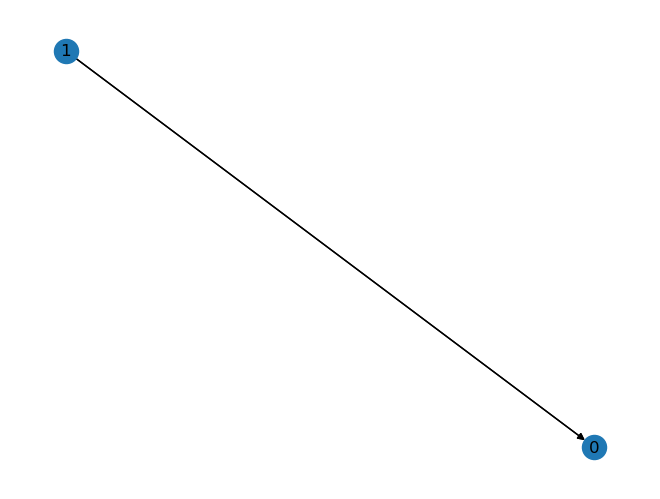

In [3]:
vr = ckt.ring(Kinds.IVS,Kinds.R,1)
vr.elements[0].attr = 1
# vr.elements[-1].v = 4
vr.elements[0].i = 0.5

print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Create Solver

In [4]:
input = Input(vr)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:73: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [5]:
input.truth_mask

[True, False, True, False, False, False]

In [6]:
import time

model = Solver(input=input, state=State.Solve)
start_time = time.time()
X = model()
end_time = time.time()
X

tensor([[-76.205],
        [ 76.205],
        [ 10.000],
        [ 10.000],
        [-10.000]], grad_fn=<LinalgSolveExBackward0>)

In [7]:
model.attr

Parameter containing:
tensor([10.000,  0.131], requires_grad=True)

In [8]:
model.all_knowns_mask

tensor([ True, False])

In [9]:
model.attr[model.all_knowns_mask]

tensor([10.], grad_fn=<IndexBackward0>)

In [10]:
model.init_known_attr_mask()

tensor([ True, False])

In [11]:
model.init_attr()

tensor([10.000,  0.581])

In [12]:
print(f'execution time = {(end_time - start_time)*1000} ms')

execution time = 1.0008811950683594 ms


# Learn attributes

In [13]:
num_epochs = 10000
prev_loss = 0.1

model = Solver(input=input, state=State.Solve)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)
loss, _ = lrn.train(model,optimizer,nn.MSELoss())
print(f'init params: {model.attr}')
print(f'init loss: {loss.item()}')

epoch = 0

while(epoch < num_epochs):
    loss, _ = lrn.train(model,optimizer,nn.MSELoss())
    if(loss < 1e-11):
            break
    epoch += 1
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

print(f'Done! at {epoch} passes')
print(f'solution = {model()}')
print(f"attributes = {model.attr}")

init params: Parameter containing:
tensor([10.000,  0.406], requires_grad=True)
init loss: 331.15081787109375
Done! at 10000 passes
solution = tensor([[ -1.012],
        [  1.012],
        [ 10.000],
        [ 10.000],
        [-10.000]], grad_fn=<LinalgSolveExBackward0>)
attributes = Parameter containing:
tensor([10.000,  9.883], requires_grad=True)
